# 0. 준비

In [ ]:
#!pip install numpy
#!pip install opencv-python
#!pip install matplotlib
#!pip install scikit-image
#!pip install tqdm

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join
from glob import glob
import os
from skimage.morphology import skeletonize
from skimage.util import invert

### 이미지 출력

In [3]:
plt.rcParams['figure.figsize'] = (5, 5)

In [4]:
# 이미지 출력 함수

# 1. 이미지를 출력하는 함수
def show(img, mode='c'):
  # grayscale
  if mode == 'g':
    plt.imshow(img, cmap='gray')
  else:
    plt.imshow(img)

# 2. 2개의 이미지를 나란히 출력하는 함수
def show_2(img1, img2, mode='c'):
  plt.figure(figsize=(6, 3))
  # grayscale
  if mode == 'g':
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
  else:
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)

# 3. 3개의 이미지를 나란히 출력하는 함수
def show_3(img1, img2, img3, mode='c'):
    plt.figure(figsize=(9, 3))
    # grayscale
    if mode == 'g':
        plt.subplot(1, 3, 1)
        plt.imshow(img1, cmap='gray')
        plt.subplot(1, 3, 2)
        plt.imshow(img2, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(img3, cmap='gray')
    else:
        plt.subplot(1, 3, 1)
        plt.imshow(img1)
        plt.subplot(1, 3, 2)
        plt.imshow(img2)
        plt.subplot(1, 3, 3)
        plt.imshow(img3)

### 데이터 불러오기

In [6]:
train_path = 'data/train/train_ref'
test_path = 'data/test/test2'

# 모든 BMP 파일 경로를 정렬하여 리스트에 저장
list_train = sorted(glob(join(train_path, '*.BMP')))
list_test = sorted(glob(join(test_path, '*.BMP')))
print(len(list_train), len(list_test))

# train: 477, test: 1428

477 1428


In [ ]:
train_img = []
test_img = []
train_target_list = []
test_target_list = []

# list_train, list_test: 이미지 경로가 저장된 배열
# 이미지를 읽어 배열에 저장
for path in tqdm(list_train):
    train_img.append(cv2.imread(path, 0))  # grayscale로 읽기
    train_target_list.append(os.path.basename(path).split('.')[0])  # target list

for path in tqdm(list_test):
    test_img.append(cv2.imread(path, 0))   # grayscale로 읽기
    test_target_list.append(os.path.basename(path).split('_')[0])  # target list

uniqe_test_target_list = list(sorted(set(test_target_list)))

In [ ]:
print(len(train_img), len(test_img), train_img[0].shape, test_img[0].shape)

477 1428 (256, 256) (256, 256)


In [ ]:
print('train target list: ', len(train_target_list),train_target_list[:5])
print('test target list: ', len(test_target_list),test_target_list[:5])
print('unique test target list: ', len(uniqe_test_target_list),uniqe_test_target_list[:5])

train target list:  477 ['1', '10', '100', '101', '102']
test target list:  1428 ['100', '100', '100', '101', '101']
unique test target list:  477 ['1', '10', '100', '101', '102']


# 1. 전처리


In [8]:
# 전처리 함수
def preprocessing(img, draw=False):
  # 1) 노이즈 제거
  # median filter 이용
  img_blur = cv2.medianBlur(img, 5)
  img_blur = cv2.medianBlur(img_blur, 5)

  # 2) 이진화
  img_bin = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
  # 이미지 반전
  img_bin = 255 - img_bin
  # 이진화한 이미지 노이즈 제거
  img_bin = cv2.medianBlur(img_bin, 5)

  # 3) 세선화
  img_skl = skeletonize(img_bin // 255)  # pixel values: 255 -> 1
  img_skl = img_skl.astype(np.uint8)
  img_skl[img_skl == 1] = 255  # pixel values: 1 -> 255

  if draw == True:
    show_3(img_blur, img_bin, img_skl, 'g')

  # 세선화한 이미지 반환
  return img_skl

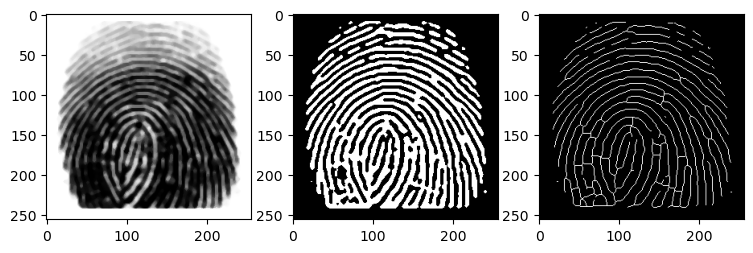

In [ ]:
# train set의 첫 번째 이미지 전처리 및 시각화
img_skl = preprocessing(train_img[0], True)

# 2. 특징점 추출

## 1) 지문 영역 컨투어 그리기

In [9]:
# 경계선을 끝점으로 탐지하지 않도록 외곽선 그린 이미지 반환

def get_contour(img, draw=False):
  img_cont = img.copy()

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))  # 3x3 kernel
  # [[0 1 0]
  #  [1 1 1]
  #  [0 1 0]]

  # 모폴로지 연산 -> 관심 영역(지문) 채우기
  img_morph = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=8)

  # 컨투어 찾기
  contours, _ = cv2.findContours(img_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # 컨투어를 이미지에 그리기
  cv2.drawContours(img_cont, contours, -1, 125, 3)  # 회색

  if draw == True:
      show_3(img, img_morph, img_cont, 'g')

  return img_cont

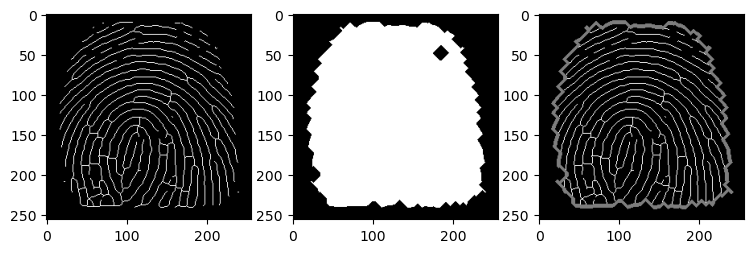

In [ ]:
# train set의 첫 번째 이미지 컨투어링
img_cont = get_contour(img_skl, True)

## 2) 끝점, 분기점 찾기

In [ ]:
# 초기 코드

def get_fp_feature_old(img):
  # 3x3 window
  ks = 3
  rows, cols = img.shape[:2]

  # 분기점
  bif = []
  # 끝점
  end = []

  for i in range(1, rows-1):  # y축
      for j in range(1, cols-1):  # x축
          # window 중심이 흰색인 경우
          if img[i, j] == 255:
              white_pixels = 0
              black_pixels = 0

              # 주변 픽셀
              for k_i in range(i-1, i+2):
                  for k_j in range(j-1, j+2):
                      # 흰색
                      if img[k_i, k_j] == 255:
                          white_pixels += 1
                      # 검정색
                      elif img[k_i, k_j] == 0:
                          black_pixels += 1

              bif_tmp = []
              end_tmp = []
              # 주변 픽셀 중 흰색이 4개, 나머지가 검정색인 경우 **bif**
              if white_pixels == 4 and black_pixels == 5:
                  bif_tmp.append(j)  # x 좌표
                  bif_tmp.append(i)  # y 좌표
                  bif_tmp.append(255)  # type
                  bif.append(bif_tmp)
              # 주변 픽셀 중 흰색이 2개, 나머지가 검정색인 경우 **end**
              elif white_pixels == 2 and black_pixels == 7:
                  end_tmp.append(j)  # x 좌표
                  end_tmp.append(i)  # y 좌표
                  end_tmp.append(0)  # type
                  end.append(end_tmp)
  return end, bif

In [ ]:
%%time
end, bif = get_fp_feature_old(img_cont)

Wall time: 112 ms


In [10]:
# 개선 코드

def get_fp_feature(img):
    # 3x3 window
    ks = 3
    rows, cols = img.shape[:2]
    # 분기점
    bif = []
    # 끝점
    end = []

    # 주변 픽셀 표시하기 위한 이미지 크기의 zero 배열
    surrounding_pixels = np.zeros((rows, cols), dtype=np.uint8)

    # 이미지 내 흰색 픽셀 좌표를 배열에 저장
    white_pixels = np.argwhere(img == 255)

    # 각 흰색 픽셀의 주변 픽셀 확인
    for pixel in white_pixels:
        # i = y 좌표
        # j = x 좌표
        i, j = pixel[0], pixel[1]

        # 윈도우 내의 주변 픽셀 표시
        surrounding_pixels[i-1:i+2, j-1:j+2] = img[i-1:i+2, j-1:j+2]

        # 윈도우 내의 주변 픽셀 중 흰색 픽셀, 검정색 픽셀 개수 합 계산
        white_count = np.sum(surrounding_pixels[i-1:i+2, j-1:j+2] == 255)
        black_count = np.sum(surrounding_pixels[i-1:i+2, j-1:j+2] == 0)

        bif_tmp = []
        end_tmp = []

        # 주변 픽셀 중 흰색이 4개, 나머지가 검정색인 경우 **bif**
        if white_count == 4 and black_count == 5:
            bif_tmp.append(j)  # x 좌표
            bif_tmp.append(i)  # y 좌표
            bif_tmp.append(255)  # type
            bif.append(bif_tmp)
        # 주변 픽셀 중 흰색이 2개, 나머지가 검정색인 경우 **end**
        elif white_count == 2 and black_count == 7:
            end_tmp.append(j)  # x 좌표
            end_tmp.append(i)  # y 좌표
            end_tmp.append(0)  # type
            end.append(end_tmp)

    return end, bif

In [ ]:
%%time
end, bif = get_fp_feature(img_cont)

Wall time: 41.7 ms


In [ ]:
print(end[:5])
print(bif[:5])

[[96, 18, 0], [161, 20, 0], [171, 23, 0], [180, 27, 0], [162, 29, 0]]
[[109, 21, 255], [108, 22, 255], [109, 22, 255], [175, 79, 255], [175, 80, 255]]


## 3) 끝점, 분기점 시각화

In [11]:
def draw_fp_feature(img, end, bif):
  # 원본 이미지에 특징점 찍기
  img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  # end
  for point in end:
      cv2.circle(img_color, (point[0], point[1]), 1, (255, 0, 0), -1)  # 끝점: 빨간색 점
  # bif
  for point in bif:
      cv2.circle(img_color, (point[0], point[1]), 1, (0, 0, 255), -1)  # 분기점: 파란색 점

  return img_color

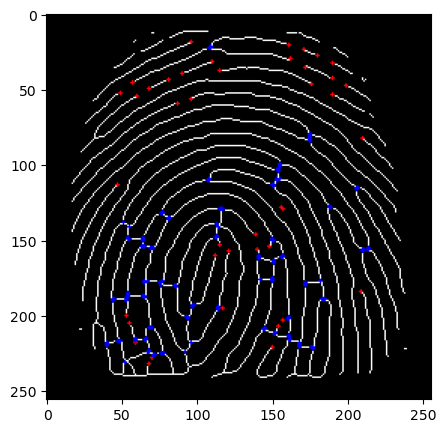

In [ ]:
feature_color = draw_fp_feature(img_skl, end, bif)
show(feature_color)

# 3. 매칭

## 1) 매칭 함수

In [12]:
def get_match_points(feat_query, feat_train, draw=False, img1=None, img2=None):
  # BFMatcher 생성
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

  # 특징점 배열 형식 변환
  feat_query_converted = np.array(feat_query, dtype=np.float32)
  feat_train_des_converted = np.array(feat_train, dtype=np.float32)

  # 매칭 수행하고 매칭된 특징점을 배열로 저장
  matches = bf.match(feat_query_converted, feat_train_des_converted)

  # 매칭된 특징점 간의 거리 저장
  matched_distances = [m.distance for m in matches]

  # 매칭된 특징점 개수
  len_match = len(matches)

  # 매칭된 특징점의 최대 거리
  max_dist = max(matched_distances)
  # 매칭된 특징점의 최소 거리
  min_dist = min(matched_distances)


  # 매칭된 특징점 시각화
  if draw and img1 is not None and img2 is not None:
    # 두 이미지 가로로 이어붙이기
    combined_img = np.hstack((img1, img2))

    # 매칭된 특징점 잇기
    for m in matches:
        query_idx = m.queryIdx
        train_idx = m.trainIdx
        query_pt = (int(feat_query[query_idx][0]), int(feat_query[query_idx][1]))
        train_pt = (int(feat_train[train_idx][0] + img1.shape[1]), int(feat_train[train_idx][1]))

        # 무작위 색상
        color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

        # 연결선 그리기
        cv2.line(combined_img, query_pt, train_pt, color, 1)

    show(combined_img)

  # 매칭된 특징점 최대 거리, 최소 거리, 개수 반환
  return max_dist, min_dist, len_match

data/test/test2\100_type1.BMP 100 data/train/train_ref\100.BMP


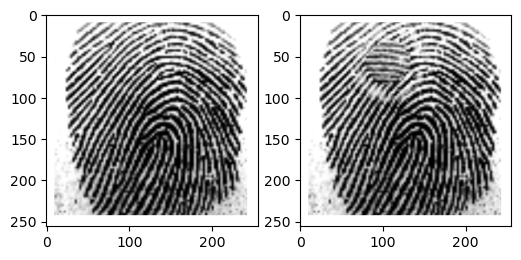

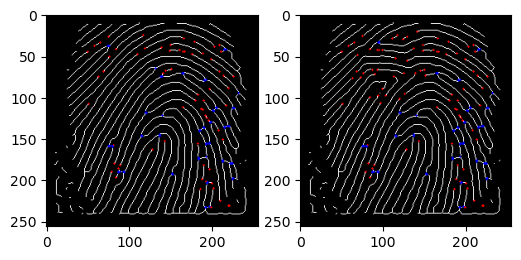

In [ ]:
# 이미지 2개로 매칭 함수 호출 및 시각화 테스트
target_path = list_test[0]
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
print(target_path, basename, train_sample_path)
img_1 = cv2.imread(train_sample_path, 0)
img_2 = cv2.imread(target_path, 0)
show_2(img_1, img_2, 'g')

img_skl_1 = preprocessing(img_1, False)
img_skl_2 = preprocessing(img_2, False)
img_cont_1 = get_contour(img_skl_1, False)
img_cont_2 = get_contour(img_skl_2, False)
end_1, bif_1 = get_fp_feature(img_cont_1)
end_2, bif_2 = get_fp_feature(img_cont_2)
feature_color_1 = draw_fp_feature(img_skl_1, end_1, bif_1)
feature_color_2 = draw_fp_feature(img_skl_2, end_2, bif_2)
show_2(feature_color_1, feature_color_2)

In [ ]:
feat_train = np.concatenate([end_1, bif_1]).astype(np.uint8)
feat_test = np.concatenate([end_2, bif_2]).astype(np.uint8)

18.439088821411133
0.0
151


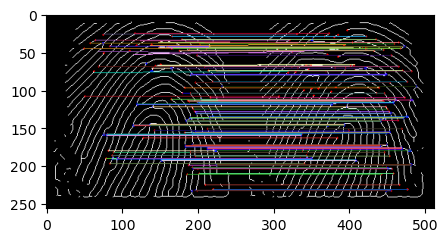

In [ ]:
max_dist, min_dist, len_match = get_match_points(feat_test, feat_train, draw=True, img1=feature_color_1, img2=feature_color_2)
print(max_dist)
print(min_dist)
print(len_match)

## 2) 전체 지문 특징점 추출

In [ ]:
# train sample 특징점 추출

dict_train_feat = {}

# 모든 train sample을 돌면서
for t in tqdm(list_train):
    basename = os.path.basename(t)
    img = cv2.imread(t, 0)
    # 전처리
    img = preprocessing(img)

    # 특징점 추출
    con_img = get_contour(img)
    db_end, db_bif = get_fp_feature(con_img)
    feat_train = np.concatenate([db_end, db_bif]).astype(np.uint8)

    # dictionary에 저장
    dict_train_feat[basename] = feat_train

100%|████████████████████████████████████████████████████████████████████████████████| 477/477 [00:21<00:00, 21.68it/s]


In [ ]:
# test sample 특징점 추출

arr_test_feat = []

# 모든 test sample을 돌면서
for t in tqdm(list_test):
    img = cv2.imread(t, 0)
    # 전처리
    img = preprocessing(img)

    # 특징점 추출
    con_img = get_contour(img)
    q_end, q_bif = get_fp_feature(con_img)
    feat_query = np.concatenate([q_end, q_bif]).astype(np.uint8)

    # 베열에 저장
    arr_test_feat.append(feat_query)

100%|██████████████████████████████████████████████████████████████████████████████| 1428/1428 [01:01<00:00, 23.30it/s]


In [ ]:
print(len(dict_train_feat))
print(len(arr_test_feat))

477
1428


## 3) 동일 지문 찾기

In [13]:
# 매칭 정보 저장 함수
def match_all(arr_test_feat, dict_train_feat):
    dict_result = {}

    # 각각의 test sample에 대해 반복
    for index, test_feat in tqdm(enumerate(arr_test_feat), total=1428):
        test_result = {}

        # 각각의 train sample에 대해 반복
        for train_name, train_feat in dict_train_feat.items():

          max_dist, min_dist, len_match = get_match_points(test_feat, train_feat)

          test_result[train_name] = [max_dist, min_dist, len_match, len(test_feat), len(train_feat)]

        dict_result[index] = test_result

    return dict_result

In [ ]:
result = match_all(arr_test_feat, dict_train_feat)

100%|██████████████████████████████████████████████████████████████████████████████| 1428/1428 [02:09<00:00, 11.03it/s]


In [ ]:
print(len(result))
print(len(result[0]))
result[0]

1428
477


{'1.BMP': [30.870698928833008, 1.0, 35, 176, 205],
 '10.BMP': [27.20294189453125, 1.0, 68, 176, 280],
 '100.BMP': [18.439088821411133, 0.0, 151, 176, 158],
 '101.BMP': [39.20458984375, 1.0, 26, 176, 146],
 '102.BMP': [36.055511474609375, 0.0, 47, 176, 157],
 '104.BMP': [27.658634185791016, 0.0, 57, 176, 231],
 '105.BMP': [30.01666259765625, 2.0, 49, 176, 270],
 '106.BMP': [27.166154861450195, 0.0, 49, 176, 180],
 '107.BMP': [40.71854782104492, 1.0, 31, 176, 148],
 '108.BMP': [20.808652877807617, 0.0, 38, 176, 198],
 '11.BMP': [28.0, 1.4142135381698608, 27, 176, 136],
 '111.BMP': [28.160255432128906, 0.0, 52, 176, 166],
 '112.BMP': [29.4108829498291, 0.0, 78, 176, 390],
 '113.BMP': [23.021728515625, 0.0, 58, 176, 320],
 '116.BMP': [52.39274597167969, 0.0, 42, 176, 115],
 '12.BMP': [32.06243896484375, 3.0, 24, 176, 154],
 '120.BMP': [29.832868576049805, 0.0, 55, 176, 397],
 '122.BMP': [19.84943389892578, 1.4142135381698608, 43, 176, 385],
 '123.BMP': [39.84971618652344, 1.0, 36, 176, 158

In [ ]:
# 결정 함수
def classification(match_infos, threshold):
    pred_target_list = []

    # test set 순회
    for (test_idx, match_info) in tqdm(match_infos.items()):
        # 비율이 threshold보다 큰 것이 없으면 'unregistered'로 target 저장
        pred_target = 'unregistered'

        train_targets = []
        match_ratios = []

        # train set 순회
        for (cur_train_target, arr) in match_info.items():
            # 두 이미지의 특징점 개수 평균
            fp_avg = (arr[3] + arr[4])/2
            # 두 이미지의 매칭점 개수
            fp_match = arr[2]
            # 비율
            match_ratio = fp_match / fp_avg

            train_targets.append(cur_train_target[:-4])
            match_ratios.append(match_ratio)

        # 최대 비율값의 index
        max_idx = np.argmax(match_ratios)

        # 최대 비율이 threshold보다 크면
        if match_ratios[max_idx] > threshold:
            # 해당 target을 예측 target으로 저장
            pred_target = train_targets[max_idx]

        pred_target_list.append(pred_target)

    return pred_target_list

# 4. Metric 계산

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
# metrics 출력 함수
def print_metrics(true, pred):

    # 1) confusion matrix 계산
    cm = confusion_matrix(true, pred)  # 478 x 478

    # 2) True Positive, False Positive, False Negative, True Negative 계산
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    # 3) Precision, Recall, Accuracy 계산
    # Precision
    precision = metrics.precision_score(true, pred, average= "macro", zero_division=0)
    # Recall
    recall = metrics.recall_score(true, pred, average= "macro", zero_division=0)
    # Accuracy
    accuracy = metrics.accuracy_score(true, pred)

    print(f"전체 Precision: {precision:>8.3f}")
    print(f"전체 Recall: {recall:>11.3f}")
    print(f"전체 Accuracy: {accuracy:>9.3f}")

    # 4) FAR, FRR 계산
    # FAR
    FAR = np.sum(FP) / (np.sum(FP) + np.sum(TN))
    # FRR
    FRR = np.sum(FN) / (np.sum(TP) + np.sum(FN))

    print(f"전체 FAR: {FAR:>14.3f}")
    print(f"전체 FRR: {FRR:>14.3f}")

## threshold 결정

In [ ]:
# pred_target_list = classification(result, threshold)
pred_target_list_06 = classification(result, 0.6)
pred_target_list_07 = classification(result, 0.7)
pred_target_list_08 = classification(result, 0.8)
pred_target_list_09 = classification(result, 0.9)

In [ ]:
print('--- [threshold = 0.6] ---')
print_metrics(test_target_list, pred_target_list_06)

print('--- [threshold = 0.7] ---')
print_metrics(test_target_list, pred_target_list_07)

print('--- [threshold = 0.8] ---')
print_metrics(test_target_list, pred_target_list_08)

print('--- [threshold = 0.9] ---')
print_metrics(test_target_list, pred_target_list_09)

--- [threshold = 0.6] ---
전체 Precision:    0.998
전체 Recall:       0.962
전체 Accuracy:     0.964
전체 FAR:          0.000
전체 FRR:          0.036
--- [threshold = 0.7] ---
전체 Precision:    0.998
전체 Recall:       0.880
전체 Accuracy:     0.882
전체 FAR:          0.000
전체 FRR:          0.118
--- [threshold = 0.8] ---
전체 Precision:    0.969
전체 Recall:       0.656
전체 Accuracy:     0.657
전체 FAR:          0.001
전체 FRR:          0.343
--- [threshold = 0.9] ---
전체 Precision:    0.649
전체 Recall:       0.265
전체 Accuracy:     0.265
전체 FAR:          0.002
전체 FRR:          0.735
